In [1]:
%load_ext autoreload
%autoreload 2

ModuleNotFoundError: No module named 'imp'

In [11]:
!pip install diffrax

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.2/193.2 kB 4.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.0/68.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.4/97.4 kB 8.0 MB/s eta 0:00:00


In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import diffrax
import matplotlib.pyplot as plt

from soromox.systems.tendon_actuated_pendulum import TendonActuatedPendulum

from controllers.MPPI import ModelPredictivePathIntegralControl

ModuleNotFoundError: No module named 'diffrax'

In [ ]:
num_links = 1
params = {
    "m": jnp.array([10.0]),
    "I": jnp.array([3.0]),
    "L": jnp.array([2.0]),
    "Lc": jnp.array([1.0]),
    "g": jnp.array([0.0, -9.81]),
}

pendulum = TendonActuatedPendulum(params=params)

nx = 2 * num_links
nu = 1

dynamics = lambda t, x, u: pendulum.forward_dynamics(t, x, (u,))

In [ ]:
N = 30
dt = 0.01
Q = jnp.diag(jnp.array([200.0]*num_links + [1.0]*num_links))
R = jnp.diag(jnp.array([0.001]*nu))
u_max = 200.0

x_eq = jnp.array([np.pi/2, 0.0])    # upright
u_eq = jnp.zeros(nu)

x0 = np.array([-np.pi / 2, 0.0])   # very far from upright

controller = ModelPredictivePathIntegralControl(dynamics, N, dt, nu, Q, R, x_eq, -u_max, u_max, sigma=100.0, correlation=0.9, covariance_type="Gaussian")

controller.auto_choose_temperature(x=x0)

998.8692889353333 0.10011319910194375


In [ ]:
controller.mu = 0.0 * jnp.ones_like(controller.control_input)

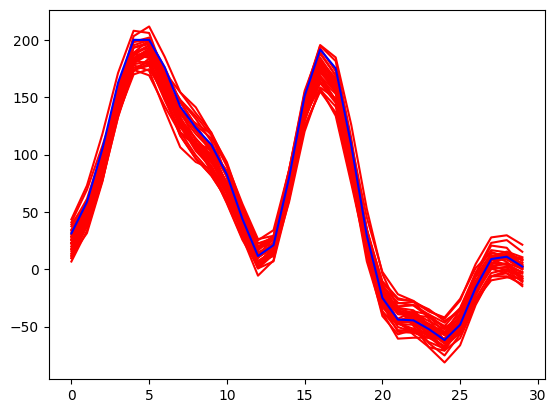

57031.1011820868
54337.222959047554


In [ ]:
for i in range(10):
    u_sample = controller.sample_u(controller.mu, controller.Sigma)
    J = controller.batch_compute_trajectory_cost(u_sample, x0)
    mu, Sigma, w = controller.update_distribution(u_sample, J, update_variance=False)
    controller.mu = mu
    controller.Sigma = Sigma

plt.plot(u_sample.squeeze().T, c='r')
plt.plot(controller.control_input.T, c='b')
plt.show()

print(controller.compute_trajectory_cost(controller.control_input, x0).squeeze())
print(controller.compute_trajectory_cost(200.0 * jnp.ones_like(controller.control_input), x0).squeeze())

In [19]:
# ---------------------------------------------------------
# 4. SIMULATION USING JAX REAL DYNAMICS
# ---------------------------------------------------------
@jax.jit
def simulate_step(t, x, u):
    sol = diffrax.diffeqsolve(terms=diffrax.ODETerm(pendulum.forward_dynamics), solver=diffrax.Tsit5(), t0=t, t1=t+dt, dt0=1e-4, y0=x, args=(u,), saveat=diffrax.SaveAt(ts=[t+dt]))
    return sol.ys

T_sim = 5.0
steps = int(T_sim / dt)

t = 0.0
x = x0

controller.solve(x, num_iter=50)

trajectory_x = [x]
trajectory_u = []
trajectory_cost = x.T @ controller.Q @ x

for step in range(steps):
    compute_times = controller.solve(x, num_iter=1)
    print(controller.compute_trajectory_cost(controller.control_input, x).squeeze(), compute_times)
    u = controller.get_control_input_and_step()
    x = np.asarray(simulate_step(t, x, u)).squeeze()
    t += dt
    trajectory_x.append(x)
    trajectory_u.append(u)
    trajectory_cost += jnp.squeeze((x[:, None] - controller.x_ref).T @ controller.Q @ (x[:, None] - controller.x_ref) + u.T @ controller.R @ u)

trajectory_x = np.array(trajectory_x).reshape(steps+1, nx, 1)
trajectory_u = np.array(trajectory_u).reshape(steps, nu, 1)

print("Finished closed loop simulation.")
print("Trajectory Cost: ", trajectory_cost * dt)

54118.950309672604 {'sampling': 0.0005090199992991984, 'trajectory cost': 0.056425884999043774, 'update': 0.0030234949990699533}
53365.426233519924 {'sampling': 0.0006886949995532632, 'trajectory cost': 0.06263669799955096, 'update': 0.003977595999458572}
52582.607059118716 {'sampling': 0.0005133220001880545, 'trajectory cost': 0.05838425699766958, 'update': 0.003093922001426108}
51771.68137741134 {'sampling': 0.000521419002325274, 'trajectory cost': 0.057223007002903614, 'update': 0.003078634999837959}
50930.11635706702 {'sampling': 0.0004864610018557869, 'trajectory cost': 0.05717708099837182, 'update': 0.0046622280024166685}
50055.480358823304 {'sampling': 0.0004649759976018686, 'trajectory cost': 0.06467918300040765, 'update': 0.003491236002446385}
49113.60940873574 {'sampling': 0.0005102930008433759, 'trajectory cost': 0.057707331998244626, 'update': 0.0030788449985266197}
48197.15786799577 {'sampling': 0.0005874339985894039, 'trajectory cost': 0.06292784000106622, 'update': 0.003

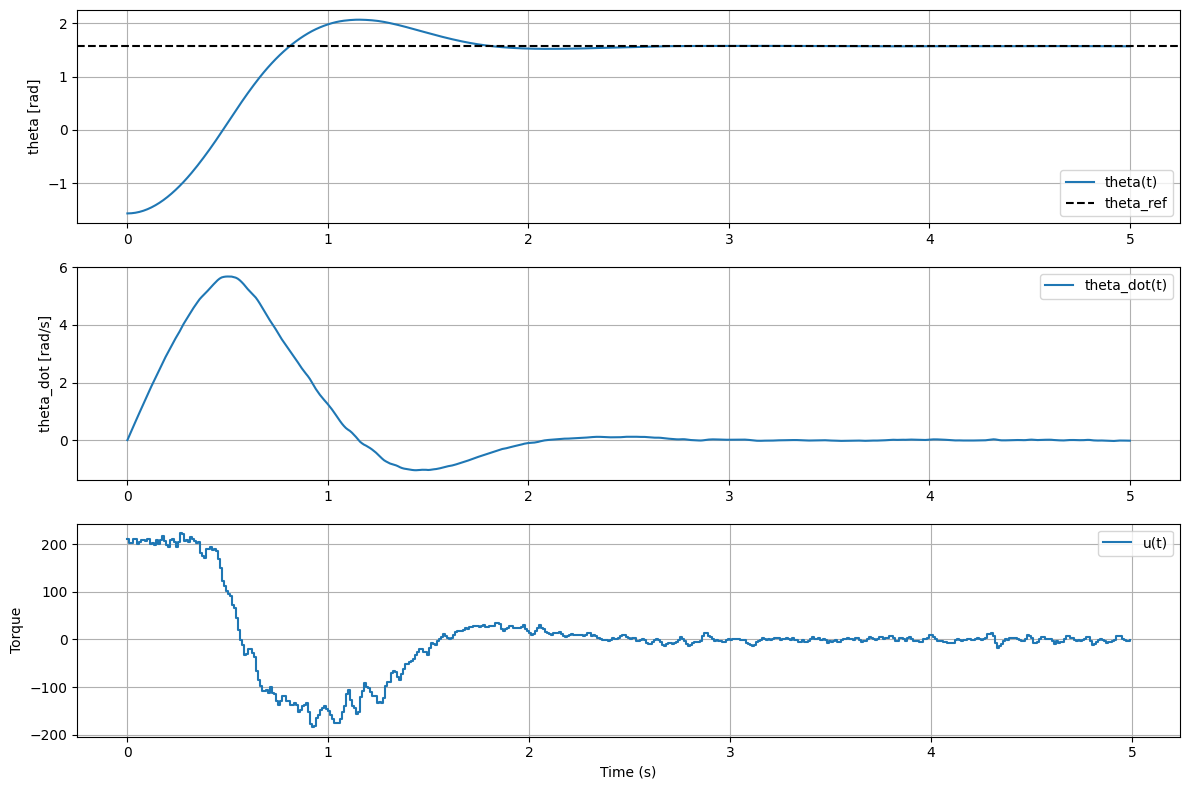

In [ ]:
import matplotlib.pyplot as plt

trajectory_x = np.array(trajectory_x)
trajectory_u = np.array(trajectory_u)
time = np.arange(trajectory_x.shape[0]) * dt

plt.figure(figsize=(12,8))

# -----------------------------
# Plot Theta
# -----------------------------
plt.subplot(3,1,1)
plt.plot(time, trajectory_x[:, 0].squeeze(), label="theta(t)")
plt.axhline(x_eq[0], color="k", linestyle="--", label="theta_ref")
plt.ylabel("theta [rad]")
plt.legend()
plt.grid(True)

# -----------------------------
# Plot Theta_dot
# -----------------------------
plt.subplot(3,1,2)
plt.plot(time, trajectory_x[:, 1].squeeze(), label="theta_dot(t)")
plt.ylabel("theta_dot [rad/s]")
plt.legend()
plt.grid(True)

# -----------------------------
# Plot Control Input
# -----------------------------
plt.subplot(3,1,3)
plt.step(time[:-1], trajectory_u[:, 0].squeeze(), where="post", label="u(t)")
plt.ylabel("Torque")
plt.xlabel("Time (s)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


(33, 1, 30) (1, 30)


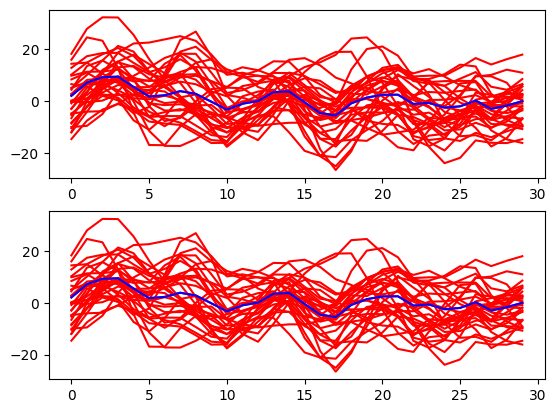

[0.43612852 2.10237996 4.0859641  4.7218259  1.28437158 4.64357386
 2.34624372 2.99077848 2.97760941 7.75852636 1.78410095 2.20183673
 2.18401567 2.49211928 1.73762525 1.81351283 4.1123319  1.49985538
 1.77649285 2.43622679 2.49945847 3.66560822 4.34280948 5.31865737
 2.39645971 3.24587789 2.49023332 1.32301231 3.4620269  8.38431269
 3.47879457 3.54144596 1.62011032]


In [ ]:
u_sample = controller.sample_u(controller.mu, controller.Sigma, add_zero_sample=True)
u_apply = controller.control_input
print(u_sample.shape, u_apply.shape)

fig, ax = plt.subplots(2, 1)
ax[0].plot(u_sample[:, 0, :].T, c='r')
ax[0].plot(u_apply[0, :], c='b')
ax[1].plot(u_sample[:, 1, :].T, c='r')
ax[1].plot(u_apply[1, :], c='b')
plt.show()

print(controller.batch_compute_trajectory_cost(u_sample, x).squeeze())